In [1]:
#!pip instal hide_code

In [2]:
from collections import Counter
from datetime import datetime, timedelta, date
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

from util.config import versioned
from util.polish import TERYT
from scrapers.pkw.sources import election_date
from analysis.utils import drop_duplicates, read_enriched, extract_companies

In [3]:
teryt = "14"

In [4]:
local_good = read_enriched(teryt)
print(f"Znaleziono {len(local_good)} osób")

Missing teryt: {'0205', '1465', '2215', '1429', '0805', '2000', '2200', '2212', '2760', '2610', '1410', '1461', '5510', '1436', '0264', '1462', '0461', '0108', '1428', '0405', '1407', '2214', '2401', '7122', '0126', '6165', '9152', '1438', '0615', '2007', '5520', '1431', '1405', '1426', '1464', '1411', '2810', '9300', '0128', '1412', '1432', '1602', '0122', '1414', '1499', '6710', '1406', '1404', '0219', '4310', '0107', '1463', '7110', '1427', '1433', '71', '0102', '1420', '1400', '0225', '1415', '2261', '2661', '1435', '2744', '1422', '6160', '1403', '3216', '2413', '3011', '5910', '0463', '1430', '1417', '1416', '2462', '1402', '0618', '2013', '3214', '1310', '0600', '1425', '1419', '2410', '1804', '1418', '2415', '1434', '0662', '1807', '7162', '6770', '1401', '3262', '1319', '1424', '1413', '0200', '1318', '6110', '3569', '3027', '2805', '1408', '1421', '0612', '0209', '0619', '2472', '59', '1409', '0804', '2800', '0661', '1437', '1601', '3202', '0120', '3601', '0419', '0403', '752

In [5]:
local_good[local_good["krs_name"] == "Jacek Adam Boczkaja"]["election_before_work"]

Series([], Name: election_before_work, dtype: timedelta64[ns])

In [6]:
local_companies = pd.DataFrame(extract_companies(local_good), columns=["KRS", "Nazwa", "Liczba ciekawych osób"])
display(local_companies)

,KRS,Nazwa,Liczba ciekawych osób
0,0000116702,WARSZAWSKA KOLEJ DOJAZDOWA w Grodzisk Mazowiecki,12
1,0000171197,MAZOWIECKI FUNDUSZ PORĘCZEŃ w Warszawa,12
2,0000146138,MIEJSKIE PRZEDSIĘBIORSTWO WODOCIĄGÓW I KANALIZ...,10
3,0000062594,POLSKA WYTWÓRNIA PAPIERÓW WARTOŚCIOWYCH w Wars...,9
4,0000019230,TOWARZYSTWO BUDOWNICTWA SPOŁECZNEGO WARSZAWA P...,8
...,...,...,...
64,0000019193,POLSKIE KOLEJE PAŃSTWOWE w Warszawa,4
65,0000007411,TOTALIZATOR SPORTOWY w Warszawa,4
66,0000376721,"PRZEDSIĘBIORSTWO KOMUNIKACJI SAMOCHODOWEJ ""POL...",4
67,0000067663,POLSKA AGENCJA PRASOWA w Warszawa,4


In [7]:
komitet_counter = Counter((elt["party"] or "").lower().strip()
        for array in local_good["elections"].to_list()
        for elt in array)
komitet_counter.most_common(5)

[('komitet wyborczy prawo i sprawiedliwość', 300),
 ('komitet wyborczy platforma obywatelska rp', 156),
 ('kw prawo i sprawiedliwość', 66),
 ('komitet wyborczy akcja wyborcza solidarność', 65),
 ('komitet wyborczy polskie stronnictwo ludowe', 46)]

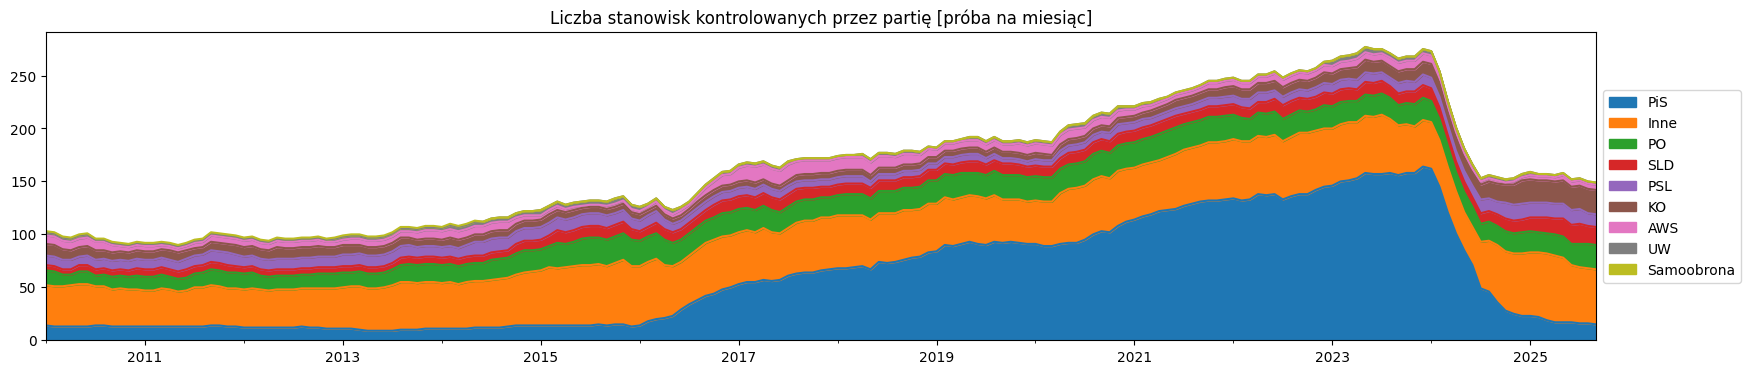

In [8]:
all_parties = set(party for parties in local_good["parties_simplified"].to_list() for party in parties)
local = {
 'Blok Samorządowy Razem',
 'Edward Pietrzyk',
 'Razem dla Radomska',
 'Razem dla Skierniewic',
 'Zbigniew Burzyński',
 'Ziemia Bełchatowska',
 'KWW Plus',
}
parties = all_parties - local
# display(parties)

def party_day_score(row):
    date = row.name
    result = [0] * len(row.index)
    global local_good
    for _i, _row in local_good.iterrows():
        for emp in _row["employment"]:
            duration = timedelta(days=365 * float(emp["employed_for"]))
            start_employed: date = emp["employed_end"] - duration
            if start_employed <= date.date() <= emp["employed_end"]:
                found_a_party = True
                for idx, col in enumerate(row.index):
                    if col in _row["parties_simplified"]:
                        result[idx] += 1
                        break
                else:
                    found_a_party = False
                if not found_a_party:
                    # Add them to "Inne" section
                    result[-1] += 1
    return pd.Series(result)

parties_aggregated = None

def show_graph(unit, unit_name, start='2010/01/01', end='2025/10/01'):
    dates = pd.date_range(start=start, end=end, freq=unit)
    df = pd.DataFrame({
        party: np.random.rand(len(dates)) for party in parties | set(["Inne"])
    }, index=dates)
    # Order dataframe columns by most recent, so we will return only at once
    df = df[["PiS","KO","PO","PSL","SLD",
             #"PO+PiS",
             "Samoobrona","AWS","UW","Inne"]]
    # display(df)
    
    party_stats = pd.DataFrame({}, columns=df.columns)
    party_stats[df.columns] = df.apply(party_day_score, axis=1)
    global parties_aggregated
    parties_aggregated = party_stats.sum(0).sort_values(ascending=False)
    descending_party_popularity = parties_aggregated.index
    party_stats = party_stats[descending_party_popularity]
    # display(party_stats)
    
    ax = party_stats.plot.area(figsize=(20, 4))
    ax.set_title(f"Liczba stanowisk kontrolowanych przez partię [próba na {unit_name}]")
    ax.legend(loc="center left", bbox_to_anchor=(1.0,0.5))

show_graph("ME", "miesiąc")

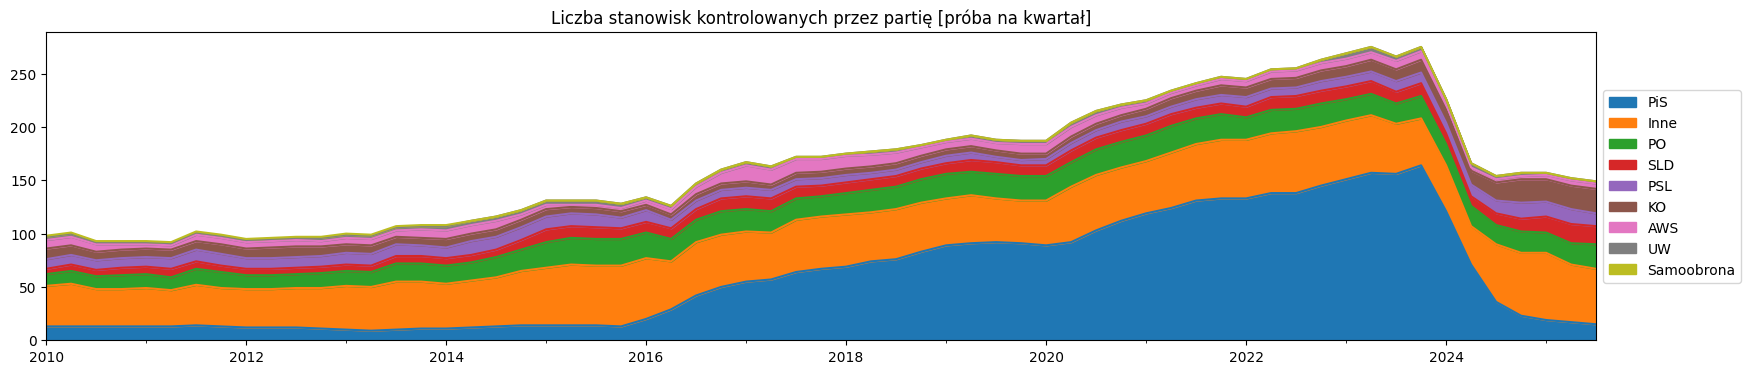

In [9]:
show_graph("QE", "kwartał")

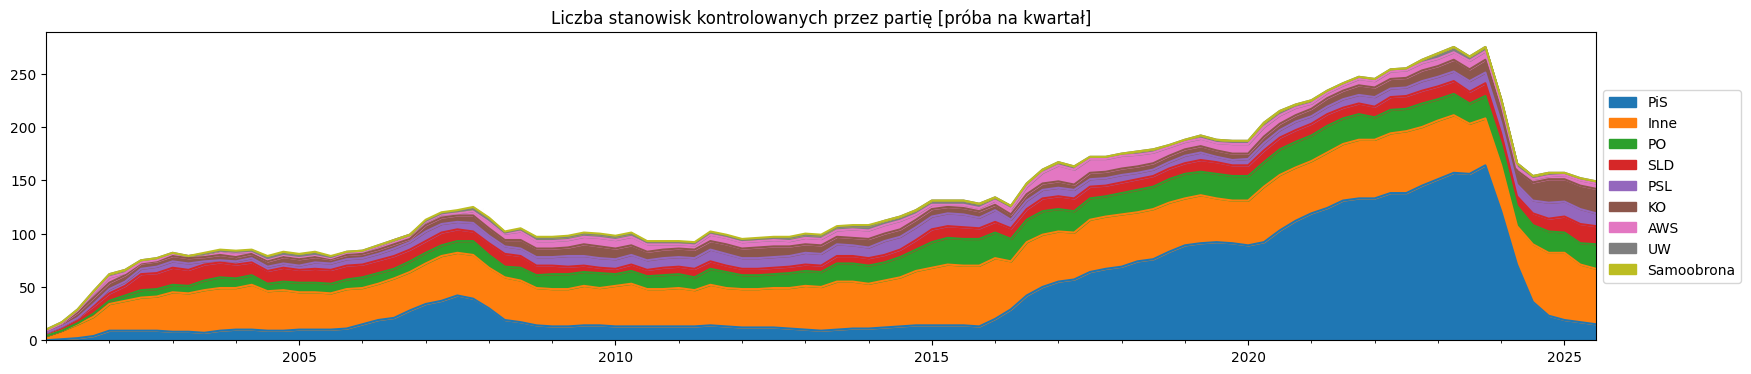

In [10]:
show_graph("QE", "kwartał", start="2001/01/01")

Text(0.5, 1.0, 'Łączny czas kontroli przez partie')

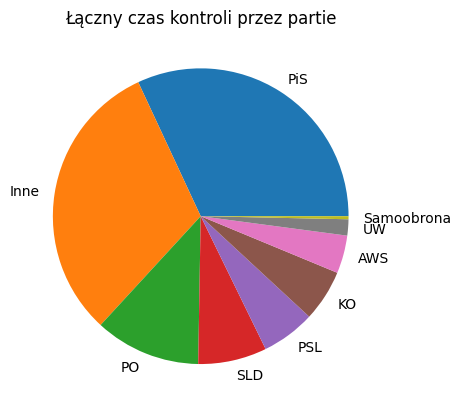

In [11]:
ax = parties_aggregated.plot.pie()
ax.set_title("Łączny czas kontroli przez partie")

Text(0.5, 0, 'Data ostatniego zatrudnienia')

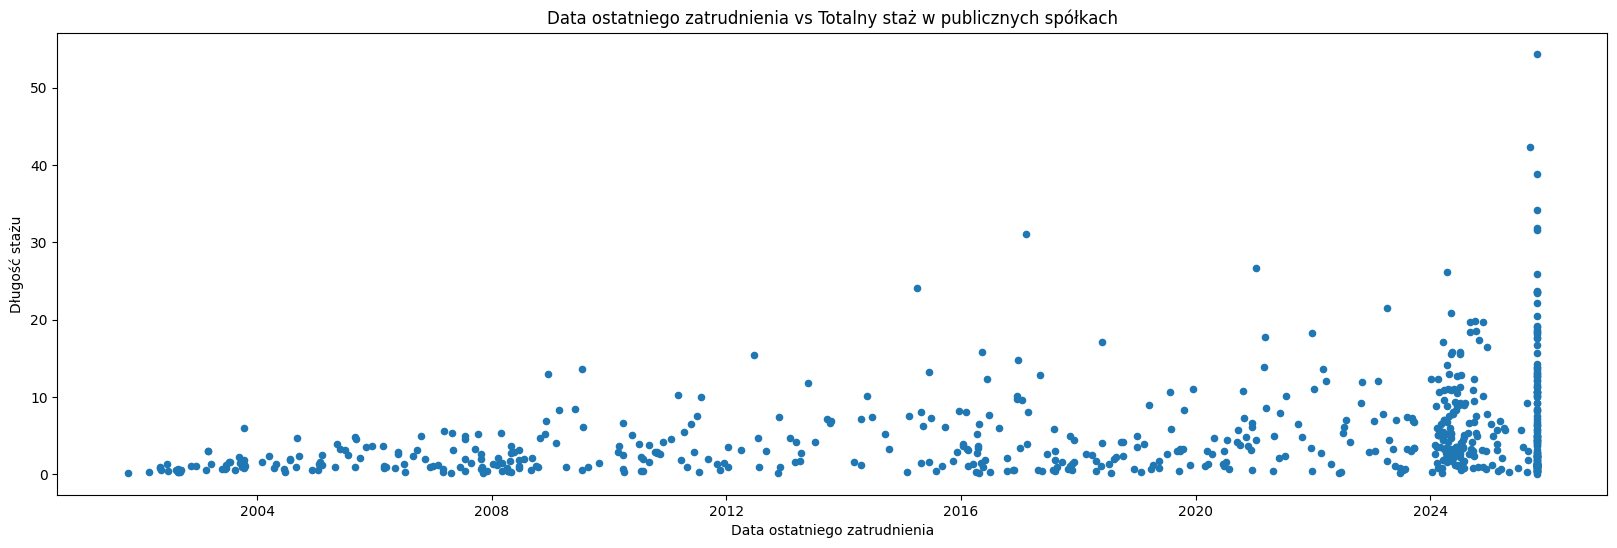

In [12]:
local_good["employed_total_years"] = local_good[("employed_total")].apply(lambda d: d.days / 365)
ax = local_good[["last_employed", "employed_total_years"]].plot.scatter(x="last_employed", y="employed_total_years", style=".", figsize=(20, 6))
ax.set_title("Data ostatniego zatrudnienia vs Totalny staż w publicznych spółkach")
ax.set_ylabel("Długość stażu")
ax.set_xlabel("Data ostatniego zatrudnienia")

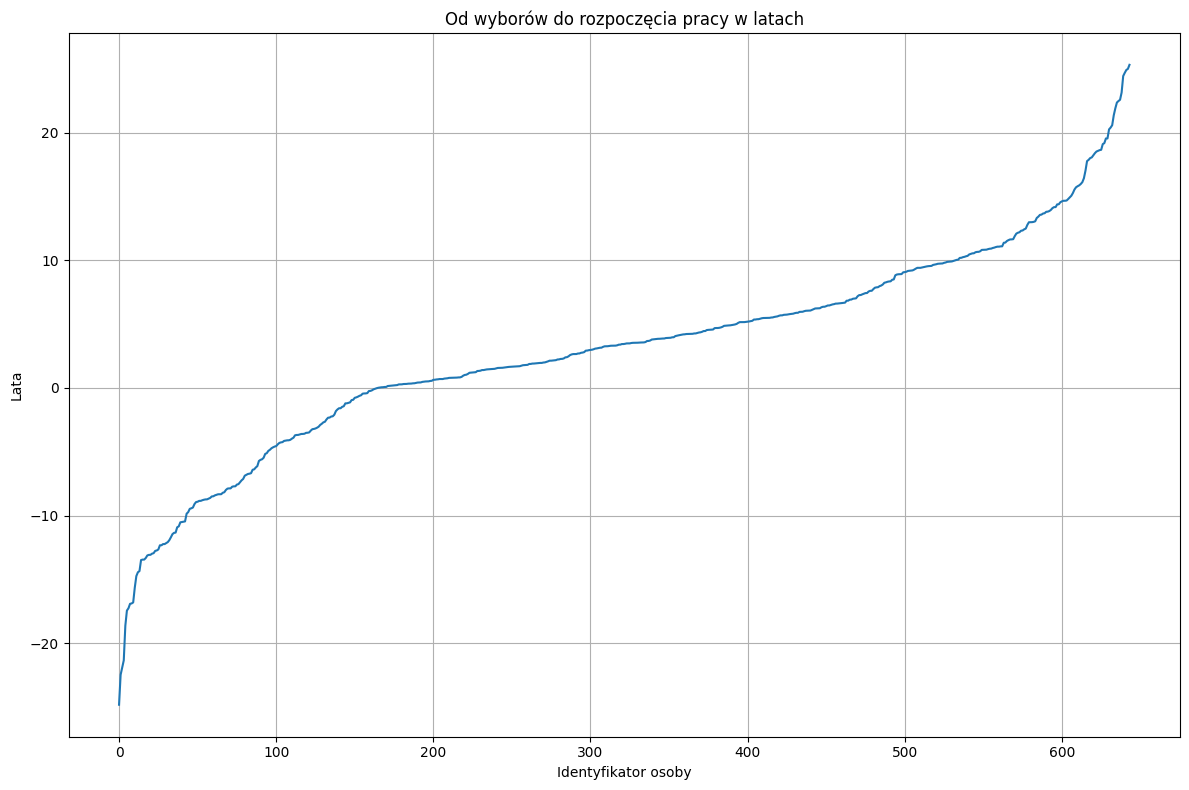

In [13]:
plt.figure(figsize=(12, 8))
ax = local_good["election_before_work"].apply(lambda duration: duration.days / 365).plot()
ax.set_xlabel("Identyfikator osoby")
ax.set_ylabel("Lata")
ax.grid(True)
ax.set_title("Od wyborów do rozpoczęcia pracy w latach")
plt.tight_layout()
plt.show()

In [14]:
d = date(year=1, month=1, day=1)
zero_delta = d - d

local_good["election_before_work_years"] = local_good["election_before_work"].apply(lambda d: d.days / 365)
longest_dur = local_good["election_before_work_years"].max()  # Use it, to put negative values after positive values of this column
local_good["election_before_work_normalized"] = local_good["election_before_work_years"].apply(lambda d: -d + longest_dur if d < 0 else d)

def calculate_position(column, smallest_good):
    # print(column)
    sort_series = local_good[column].sort_values(ascending=smallest_good)
    # display(sort_series)
    index_position = pd.Series(index=sort_series.index, data=range(len(sort_series)))
    # display(index_position)
    index_ordered = index_position.sort_index()
    # display(index_ordered)
    return index_ordered

a = calculate_position("election_before_work_normalized", smallest_good=True)
b = calculate_position("mistake_odds", smallest_good=False)
c = calculate_position("employed_total_years", smallest_good=False)
d = calculate_position("last_employed", smallest_good=False)

local_good["position"] = a + b + c +d
local_good.sort_values(by="position", inplace=True)

polish_headers = ["Pozycja", "Imię i nazwisko", "Data urodzenia", "Szansa na błąd - jeden na ...", "Od wyborów do pracy [lata]", "Łączny staż [lata]", "Ostatnie zatrudnienie", "Historia"]
cleaned = pd.DataFrame({}, columns=polish_headers)
cleaned[polish_headers] = local_good[["position", "krs_name", "birth_date", "mistake_odds", "election_before_work_years", "employed_total_years", "last_employed", "history"]]

display(cleaned.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)

,Pozycja,Imię i nazwisko,Data urodzenia,Szansa na błąd - jeden na ...,Od wyborów do pracy [lata],Łączny staż [lata],Ostatnie zatrudnienie,Historia
223,136,Adam Krzysztof Struzik,1957-01-01,78323471780356.453125,1.191781,23.589041,2025-10-26,Kandyduje w 2006 z list Komitet Wyborczy Polskiego Stronnictwa Ludowego w nieznane Pracuje od 2007-03-12 do 2025-10-26 w TRAMWAJE WARSZAWSKIE w Warszawa Kandyduje w 2010 z list KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE w nieznane Kandyduje w 2010 z list KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE w nieznane Pracuje od 2011-06-10 do 2016-05-20 w KRAJOWY FUNDUSZ KAPITAŁOWY w Warszawa Kandyduje w 2014 z list Komitet Wyborczy Polskie Stronnictwo Ludowe w nieznane
178,181,Adam Piotr Godusławski,1980-05-27,102354536985693.093750,0.279452,10.657534,2025-10-26,Kandyduje w 2010 z list KOMITET WYBORCZY PLATFORMA OBYWATELSKA RP w nieznane Kandyduje w 2014 z list Komitet Wyborczy Platforma Obywatelska RP w nieznane Pracuje od 2015-03-03 do 2025-10-26 w TOWARZYSTWO BUDOWNICTWA SPOŁECZNEGO WARSZAWA POŁUDNIE w Warszawa
183,260,Wojciech Jan Bartelski,1977-06-20,3479796515.312579,0.317808,12.068493,2025-10-26,Kandyduje w 2006 z list Komitet Wyborczy Platforma Obywatelska RP w nieznane Kandyduje w 2010 z list KOMITET WYBORCZY PLATFORMA OBYWATELSKA RP w nieznane Kandyduje w 2014 z list Komitet Wyborczy Platforma Obywatelska RP w nieznane Pracuje od 2015-03-17 do 2025-10-26 w TRAMWAJE WARSZAWSKIE w Warszawa Pracuje od 2024-05-15 do 2025-10-26 w POLIMEX MOSTOSTAL w Warszawa
278,261,Krzysztof Piotr Skolimowski,1961-09-02,10212244052994.322266,2.180822,17.649315,2025-10-26,Kandyduje w 2006 z list Komitet Wyborczy Platforma Obywatelska RP w nieznane Pracuje od 2008-03-07 do 2025-10-26 w SZYBKA KOLEJ MIEJSKA w Warszawa Kandyduje w 2010 z list KOMITET WYBORCZY PLATFORMA OBYWATELSKA RP w nieznane Kandyduje w 2014 z list Komitet Wyborczy Platforma Obywatelska RP w nieznane Kandyduje w 2024 z list KKW KOALICJA OBYWATELSKA w nieznane
224,356,Jakub Marcin Opara,1978-05-27,226393990.845183,1.205479,14.257534,2025-10-26,Kandyduje w 2006 z list Komitet Wyborczy Prawo i Sprawiedliwość w nieznane Kandyduje w 2010 z list KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ w nieznane Kandyduje w 2014 z list Komitet Wyborczy Prawo i Sprawiedliwość w nieznane Pracuje od 2016-02-04 do 2018-05-30 w PL.2012+ w Warszawa Pracuje od 2017-08-01 do 2018-07-06 w NARODOWE CENTRUM SPORTU-ROZLICZENIA w Warszawa Pracuje od 2018-05-29 do 2024-06-21 w ORLEN PALIWA w Widełka Pracuje od 2020-11-18 do 2025-10-26 w MARS FINANCE 1 w Warszawa
312,360,Tomasz Stanisław Tretter,1979-11-01,2251799813685248.000000,3.293151,7.169863,2025-10-26,Kandyduje w 2014 z list Komitet Wyborczy Platforma Obywatelska RP w nieznane Pracuje od 2018-03-07 do 2024-04-17 w WARSZAWSKA KOLEJ DOJAZDOWA w Grodzisk Mazowiecki Pracuje od 2024-10-08 do 2025-10-26 w WARSZAWSKA KOLEJ DOJAZDOWA w Grodzisk Mazowiecki
392,369,Jan Hubert Matuszkiewicz,1985-08-24,42486788937457.507812,4.980822,9.958904,2025-10-26,Kandyduje w 2010 z list KOMITET WYBORCZY WYBORCÓW PRAWICA RAZEM DLA MILANÓWKA w nieznane Pracuje od 2015-11-13 do 2025-10-26 w ZARZĄD PAŁACU KULTURY I NAUKI w Warszawa
311,373,Wiesław Mariusz Raboszuk,1966-05-21,34973031154.472748,3.273973,11.558904,2025-10-26,Kandyduje w 2006 z list Komitet Wyborczy Platforma Obywatelska RP w nieznane Kandyduje w 2010 z list KOMITET WYBORCZY PLATFORMA OBYWATELSKA RP w nieznane Pracuje od 2014-02-28 do 2015-03-18 w WARSZAWSKA KOLEJ DOJAZDOWA w Grodzisk Mazowiecki Kandyduje w 2014 z list Komitet Wyborczy Platforma Obywatelska RP w nieznane Pracuje od 2015-04-26 do 2025-10-26 w MIEJSKIE ZAKŁADY AUTOBUSOWE w Warszawa Kandyduje w 2024 z list KKW KOALICJA OBYWATELSKA w nieznane
185,405,Katarzyna Łęgiewicz,1974-01-27,58521597.277590,0.336986,10.600000,2025-10-26,Kandyduje w 2010 z list KOMITET WYBORCZY PLATFORMA OBYWATELSKA RP w nieznane Kandyduje w 2014 z list Komitet Wyborczy Platforma Obywatelska RP w nieznane Pracuje od 2015-03-24 do 2025-10-26 w SZYBKA KO

In [15]:
# Write to output
local_output = versioned.get_path(f"people_woj_{teryt}.csv")
cleaned.to_csv(local_output,index=False)

# Write to output
companies_output = versioned.get_path(f"companies_woj_{teryt}.csv")
local_companies.to_csv(companies_output,index=False)